## PPO performance analysis and deep dive

**Questions**
- What kind of scenes are hard to learn?
    - Properties (# agents), # intersections, etc...


**Procedure**
- Take a trained PPO model
- Evaluate model:
    - Single-agent mode (use policy to control a single-agent, the rest are expert-controlled)
    - Multi-agent mode (use policy to control all agents in the scene)

In [10]:
# Dependencies
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import torch
import imageio
import logging
import os
import matplotlib.pyplot as plt
from evaluation.policy_evaluation import evaluate_policy
from networks.perm_eq_late_fusion import LateFusionNet, LateFusionPolicy
from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

### Configurations 

In [3]:
MAX_FILES = 1000
DETERMINISTIC = True 
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.num_files = MAX_FILES

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])

### Helper functions 

In [4]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Load trained PPO policy

In [5]:
RL_BASE_PATH = f"../models/hr_rl/S{MAX_FILES}"
POLICY_NAME = 'policy_L0.0_S1000_I606'

rl_policy = RegularizedPPO.load(f'{RL_BASE_PATH}/{POLICY_NAME}')

INFO:root:No regularization weight specified, using default PPO.


## 1. Aggregate performance

### 1.1 Single-agent mode

In [5]:
df_res_sa = evaluate_policy(
    env_config=env_config,
    mode='policy',
    policy=rl_policy,
    num_scenes=1000,
    max_iters=100,
    controlled_agents=1,
)

100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


In [6]:
df_res_sa[METRICS].mean() * 100

goal_rate            59.0
off_road             18.0
veh_veh_collision    22.0
dtype: float64

### 1.2 Multi-agent mode

In [6]:
df_res_ma = evaluate_policy(
    env_config=env_config,
    mode='policy',
    policy=rl_policy,
    num_scenes=1000,
    num_iters=100,
    controlled_agents=20,
)

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


In [8]:
df_res_ma[METRICS].mean() * 100

goal_rate            84.856397
off_road              3.263708
veh_veh_collision    12.793734
dtype: float64

## 2. Properties of hard scenes

### 3. **Summary figures**

In [11]:
human_like_metrics = ['act_acc', 'accel_val_mae', 'steer_val_mae', 'pos_rmse', 'speed_mae']
performance_metrics = ['goal_rate', 'veh_edge_cr', 'veh_veh_cr']

In [14]:
df_hr_rl.groupby('Type')[performance_metrics].mean()

,goal_rate,veh_edge_cr,veh_veh_cr
Type,,,
train,0.10847,0.423477,0.243685
valid,0.11756,0.400298,0.235119


In [15]:
df_hr_rl.groupby('Type')[human_like_metrics].mean()

,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae
Type,,,,,
train,0.017106,2.202120,0.433476,13.270434,117.405705
valid,0.013951,2.198427,0.429229,11.465562,76.767855


In [16]:
df_hr_rl.head()

,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,Type,num_scenes
0,None,0.0,tfrecord-00001-of-01000_307.json,0,0.0750,2.326923,0.314103,7.041383,1.820937,0.0,0.0,0.0,train,100
1,None,0.0,tfrecord-00001-of-01000_307.json,1,0.0125,1.973684,0.350000,3.827434,1.104908,0.0,1.0,0.0,train,100
2,None,0.0,tfrecord-00001-of-01000_307.json,9,0.0000,2.088608,0.412025,8.245358,2.618147,0.0,0.0,0.0,train,100
3,None,0.0,tfrecord-00004-of-01000_378.json,0,0.0000,2.421053,0.503509,5.061539,1.413594,0.0,0.0,0.0,train,100
4,None,0.0,tfrecord-00004-of-01000_378.json,2,0.0000,1.500000,0.425000,1.942767,0.621620,1.0,0.0,0.0,train,100


### 3.1 What is the overall aggregated performance?

- Look at the error distribution
- What makes solving a scene hard?

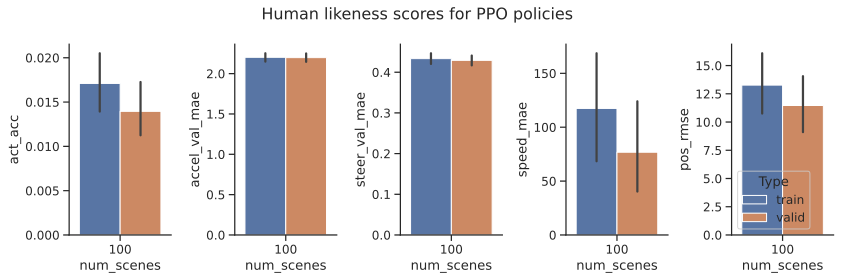

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

fig.suptitle('Human likeness scores for PPO policies', fontsize=16)

sns.barplot(data=df_hr_rl, x='num_scenes', y='act_acc', ax=axs[0], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='accel_val_mae', ax=axs[1], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='steer_val_mae', ax=axs[2], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='speed_mae', ax=axs[3], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='pos_rmse', ax=axs[4], hue='Type', legend=True)

fig.tight_layout()
sns.despine()

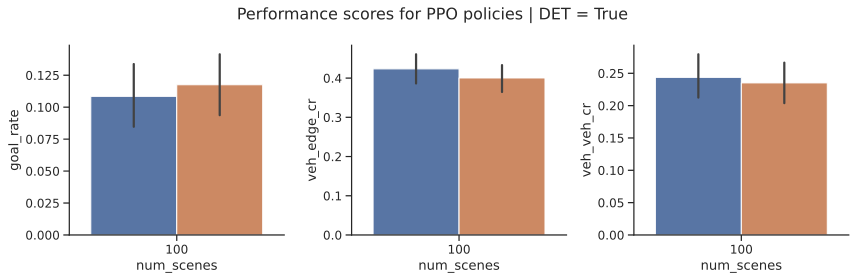

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle(f'Performance scores for PPO policies | DET = {DETERMINISTIC}', fontsize=16)

sns.barplot(data=df_hr_rl, x='num_scenes', y='goal_rate', ax=axs[0], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='veh_edge_cr', ax=axs[1], hue='Type', legend=False)

sns.barplot(data=df_hr_rl, x='num_scenes', y='veh_veh_cr', ax=axs[2], hue='Type', legend=False)

fig.tight_layout()
sns.despine()

In [35]:
len(df_hr_rl['traffic_scene'].unique())

199

In [39]:
df_hr_rl[df_hr_rl['Type'] == 'train'].groupby('traffic_scene')['goal_rate'].mean()) / 199

0.04001020194409743

In [25]:
df_hr_rl.head()

,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,Type,num_scenes
0,None,0.0,tfrecord-00001-of-01000_307.json,0,0.0750,2.326923,0.314103,7.041383,1.820937,0.0,0.0,0.0,train,100
1,None,0.0,tfrecord-00001-of-01000_307.json,1,0.0125,1.973684,0.350000,3.827434,1.104908,0.0,1.0,0.0,train,100
2,None,0.0,tfrecord-00001-of-01000_307.json,9,0.0000,2.088608,0.412025,8.245358,2.618147,0.0,0.0,0.0,train,100
3,None,0.0,tfrecord-00004-of-01000_378.json,0,0.0000,2.421053,0.503509,5.061539,1.413594,0.0,0.0,0.0,train,100
4,None,0.0,tfrecord-00004-of-01000_378.json,2,0.0000,1.500000,0.425000,1.942767,0.621620,1.0,0.0,0.0,train,100


In [ ]:
df_hr_rl.groupby('traffic_scene')

In [27]:
df_hr_rl.groupby('traffic_scene')[performance_metrics].mean()

,goal_rate,veh_edge_cr,veh_veh_cr
traffic_scene,,,
tfrecord-00001-of-01000_307.json,0.000000,0.333333,0.000000
tfrecord-00004-of-00150_246.json,0.333333,0.666667,0.000000
tfrecord-00004-of-01000_378.json,0.200000,0.400000,0.000000
tfrecord-00005-of-00150_192.json,0.111111,0.333333,0.222222
tfrecord-00005-of-01000_423.json,0.000000,1.000000,0.000000
...,...,...,...
tfrecord-00144-of-00150_65.json,0.000000,0.857143,0.000000
tfrecord-00146-of-00150_228.json,0.000000,0.571429,0.428571
tfrecord-00147-of-00150_191.json,0.000000,0.500000,0.000000


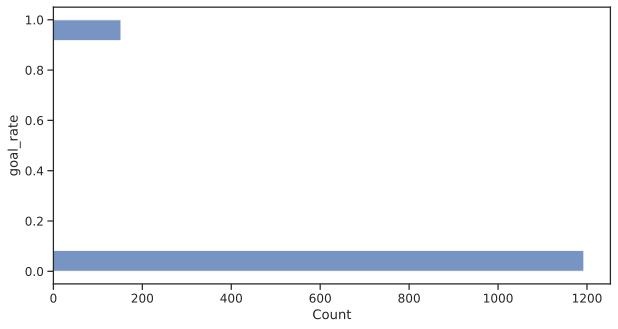

In [23]:
sns.histplot(data=df_hr_rl, y='goal_rate',);

In [10]:
#plot_agent_trajectory(df_rl_trajs_sub[df_rl_trajs_sub['agent_id'] == 0], evaluator.env.action_space.n)

In [11]:
#plot_agent_trajectory(df_rl_trajs_sub[df_rl_trajs_sub['agent_id'] == 1], evaluator.env.action_space.n)

### 3.2 Make videos of top 10 most difficult scenes / top 10 easiest scenes


In [ ]:
NUM_VIDEOS = 5

df_hr_rl.sort_values('goal_rate').head()

In [11]:
worst_scenes = df_hr_rl_all.sort_values('goal_rate')['traffic_scene'].values[:NUM_VIDEOS]

NameError: name 'df_hr_rl_all' is not defined